<a href="https://colab.research.google.com/github/DavMLPath/PhD-Theses/blob/main/Banking_Stability_Modeling_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing variables

In [139]:
from google.colab import drive

In [140]:

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [141]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
#dependent variable


In [142]:
y=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Z-score(Y)')

# # x.columns=x.iloc[0,:]

y.index=y['Date']
y.drop(columns=['Date'], inplace=True)
y
data=y.copy()

#Checking stationarity in different lags

In [143]:

from statsmodels.tsa.stattools import adfuller

# Original series
result = adfuller(y)
print("ADF p-value:", result[1])  # > 0.05 → not stationary

# First difference (trend)
result_diff = adfuller(y.diff().dropna())
print("ADF after 1 diff (d=1):", result_diff[1])

# Seasonal difference (every 3 steps)
result_seasonal_diff = adfuller(y.diff(3).dropna())
print("ADF after seasonal diff (D=1):", result_seasonal_diff[1])

#we set both d as 1
result_seasonal_diff = adfuller(y.diff(12).dropna())
print("ADF after seasonal diff (D=1):", result_seasonal_diff[1])




ADF p-value: 0.366402284861441
ADF after 1 diff (d=1): 0.00011814431222831651
ADF after seasonal diff (D=1): 8.240106258381698e-05
ADF after seasonal diff (D=1): 8.821601911530672e-05


In [144]:
import warnings
warnings.filterwarnings('ignore')


#Automatically selecting best orders based on loop

In [145]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Your time series:
# y = pd.Series(...)

# Define parameter ranges
p = q = range(0, 4)      # non-seasonal p and q
P = Q = range(0, 3)      # seasonal P and Q
d = 1                    # fixed
D = 1                    # fixed
seasonal_periods = [12]

# Create combinations
pdq = list(itertools.product(p, q))
seasonal_pdq = list(itertools.product(P, Q))

# Store results
results = []

for s in seasonal_periods:
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = SARIMAX(
                    y,
                    order=(order[0], d, order[1]),
                    seasonal_order=(seasonal_order[0], D, seasonal_order[1], s),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                model_fit = model.fit(disp=False)
                aic = model_fit.aic
                results.append({
                    'Order (p,d,q)': (order[0], d, order[1]),
                    'Seasonal (P,D,Q,s)': (seasonal_order[0], D, seasonal_order[1], s),
                    'AIC': aic
                })
                print(f"SARIMA{(order[0], d, order[1])}x{(seasonal_order[0], D, seasonal_order[1], s)} - AIC: {aic:.2f}")
            except Exception as e:
                print(f"Failed for SARIMA{(order[0], d, order[1])}x{(seasonal_order[0], D, seasonal_order[1], s)} - {e}")
                continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AIC').reset_index(drop=True)

# Print best models
print("\nTop SARIMA Models:")
print(results_df.head())


SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 468.18
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 368.61
SARIMA(0, 1, 0)x(0, 1, 2, 12) - AIC: 324.14
SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC: 408.22
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC: 371.54
SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC: 322.09
SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC: 331.08
SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC: 325.30
SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC: 320.50
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC: 404.69
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC: 304.83
SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC: 273.13
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC: 342.79
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC: 313.79
SARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC: 272.07
SARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC: 280.76
SARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC: 276.78
SARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC: 269.05
SARIMA(0, 1, 2)x(0, 1, 0, 12) - AIC: 403.01
SARIMA(0, 1, 2)x(0, 1, 1, 12) - AIC: 302.95
SARIMA(0, 1, 2)x(0, 1, 2, 12) - AIC: 271.97
SARIMA(0, 1, 2)x(1, 1, 0, 12) - AIC: 340.25
SARIMA(0, 1, 2)x(1, 1, 1, 12) - 

In [146]:
# Top SARIMA Models:
#   Order (p,d,q) Seasonal (P,D,Q,s)         AIC
# 0     (0, 1, 2)       (1, 1, 2, 3)  372.596970
# 1     (0, 1, 2)       (0, 1, 2, 3)  379.545997
# 2     (1, 1, 2)       (0, 1, 2, 3)  379.756675
# 3     (0, 1, 2)       (2, 1, 2, 3)  380.420592
# 4     (2, 1, 2)       (0, 1, 2, 3)  380.491842

In [147]:
y_s=y-y.shift(1)
y_s.dropna(inplace=True)
y_s

,Z-score
Date,
2013-02-01,0.429852
2013-03-01,-0.614530
2013-04-01,-1.349483
2013-05-01,2.562559
2013-06-01,-0.797039
...,...
2024-08-01,0.994868
2024-09-01,0.930966
2024-10-01,-2.251795


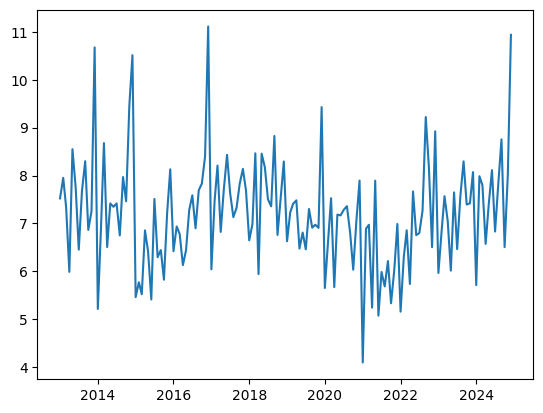

In [148]:
from matplotlib import pyplot as plt
plt.plot(y)

In [149]:
monthly_data_seasonal_diff = y.diff(3).dropna()
# Based on these plots, decide on D (0 or 1)
#monthly_data_seasonal_diff.values

In [150]:
result = adfuller(monthly_data_seasonal_diff)
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", "{:.8f}".format(float(p_value)))

ADF Statistic: -4.704861016850169
p-value: 0.00008240


In [151]:
print(type(y))

<class 'pandas.core.frame.DataFrame'>


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller

In [153]:
train_data = y[:int(0.90*(len(y)))]
test_data = y[int(0.90*(len(y))):]

In [154]:
print(len(train_data))
print(len(test_data))

129
15


#ACF/PACF for y and seasonal differenced y

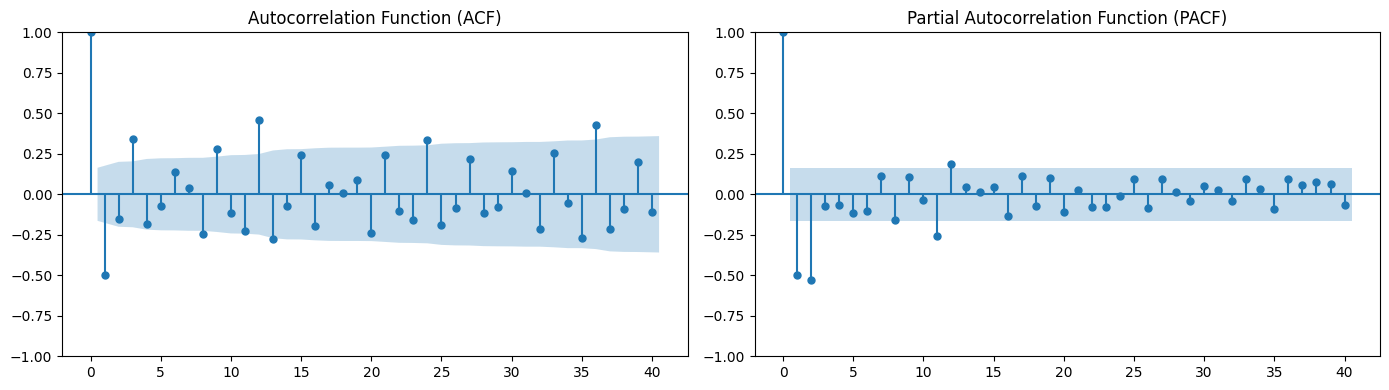

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example data (replace 'data' with your real series)
# data = pd.Series(np.random.randn(100))  # Replace this with your actual data

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

lags = 40  # Number of lags to display

# ACF
plot_acf(y_s, ax=axes[0], lags=lags)
axes[0].set_title("Autocorrelation Function (ACF)")
# axes[0].set_xticks(np.arange(0, lags + 1, 1))  # Show every lag

# PACF
plot_pacf(y_s, ax=axes[1], lags=lags, method='ywm')
axes[1].set_title("Partial Autocorrelation Function (PACF)")
# axes[1].set_xticks(np.arange(0, lags + 1, 1))  # Show every lag

plt.tight_layout()
plt.show()


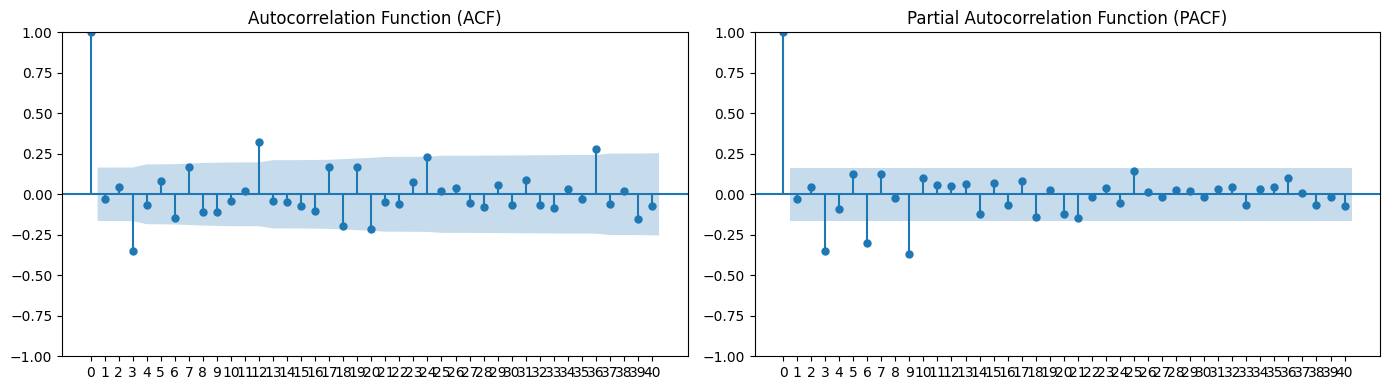

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example data (replace 'data' with your real series)
# data = pd.Series(np.random.randn(100))  # Replace this with your actual data

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

lags = 40  # Number of lags to display

# ACF
plot_acf(monthly_data_seasonal_diff, ax=axes[0], lags=lags)
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xticks(np.arange(0, lags + 1, 1))  # Show every lag

# PACF
plot_pacf(monthly_data_seasonal_diff, ax=axes[1], lags=lags, method='ywm')
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xticks(np.arange(0, lags + 1, 1))  # Show every lag

plt.tight_layout()
plt.show()



In [157]:
train_data=train_data.astype(float)

In [158]:
from statsmodels.tsa.stattools import adfuller
# Test for stationarity on the seasonally differenced series
seasonal_diff = data.diff(12).dropna()
adf_test = adfuller(seasonal_diff)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Statistic: -4.6890872674727815
p-value: 8.821601911530672e-05


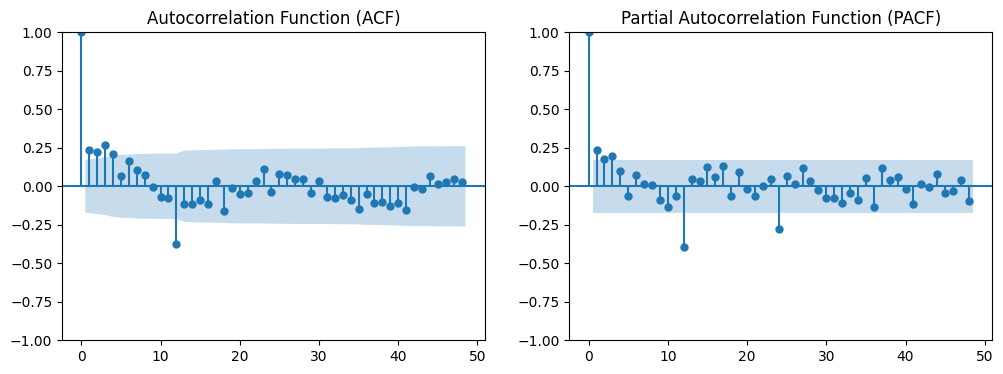

In [159]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data.diff(12).dropna(),  ax=axes[0], lags=48)
axes[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(data.diff(12).dropna(), ax=axes[1], lags=48)
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

#Model evaluation

In [160]:
# dict_ac=pd.DataFrame({'pdq':l1,'aic':l2})
# dict_ac[dict_ac['aic']==min(dict_ac['aic'])]

In [161]:
!pip install pmdarima

In [162]:
data

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


In [163]:
train_data = data[:int(0.90*(len(y)))]
test_data = data[int(0.90*(len(y))):]

In [164]:
# from statsmodels.tsa.arima.model import ARIMA
# #(0, 1, 2)       (1, 1, 2, 3)
# # If the data is already stationary (d=0)
model = ARIMA(train_data, order=(0,1 ,2), seasonal_order=(1,1,2,3))
fitted = model.fit()

print(fitted.summary())

                                    SARIMAX Results                                    
Dep. Variable:                         Z-score   No. Observations:                  129
Model:             ARIMA(0, 1, 2)x(1, 1, 2, 3)   Log Likelihood                -180.791
Date:                         Sun, 27 Apr 2025   AIC                            373.581
Time:                                 12:37:51   BIC                            390.551
Sample:                             01-01-2013   HQIC                           380.475
                                  - 09-01-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8628      0.075    -11.499      0.000      -1.010      -0.716
ma.L2          0.0260      0.091      0.287      0.774     

##ARIMA (0,1,2), (0,1,2,12)

In [188]:
from statsmodels.tsa.arima.model import ARIMA

# If the data is already stationary (d=0)
model = ARIMA(train_data, order=(0,1 ,2), seasonal_order=(0,1,2,12))
fitted = model.fit()

print(fitted.summary())

                                    SARIMAX Results                                     
Dep. Variable:                          Z-score   No. Observations:                  129
Model:             ARIMA(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -157.236
Date:                          Sun, 27 Apr 2025   AIC                            324.472
Time:                                  12:39:09   BIC                            338.240
Sample:                              01-01-2013   HQIC                           330.061
                                   - 09-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8049      0.091     -8.824      0.000      -0.984      -0.626
ma.L2          0.0501      0.116      0.433      0.

##ARIMA 3,1,0-0,1,1,12  evaluated by model of auto_arima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# If the data is already stationary (d=0)
model = ARIMA(train_data, order=(3,1 ,0), seasonal_order=(0,1,1,12))
fitted = model.fit()

print(fitted.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            Z-score   No. Observations:                  129
Model:             ARIMA(3, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -158.372
Date:                            Sun, 27 Apr 2025   AIC                            326.745
Time:                                    07:26:52   BIC                            340.513
Sample:                                01-01-2013   HQIC                           332.334
                                     - 09-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7557      0.091     -8.332      0.000      -0.933      -0.578
ar.L2         -0.5308      0.098   

##ARIMA  (0, 1, 3)      (2, 1, 2, 12)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# If the data is already stationary (d=0)
model = ARIMA(train_data, order=(0,1 ,3), seasonal_order=(2,1,2,12))
fitted = model.fit()

print(fitted.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                       
Dep. Variable:                               Z-score   No. Observations:                  129
Model:             ARIMA(0, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood                -156.023
Date:                               Sun, 27 Apr 2025   AIC                            328.047
Time:                                       09:51:31   BIC                            350.076
Sample:                                   01-01-2013   HQIC                           336.989
                                        - 09-01-2023                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7707      0.092     -8.334      0.000      -0.952      -0.589
ma.L2      

##ARIMA (2,1,1, -1,0,1,3)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# If the data is already stationary (d=0)
model = ARIMA(train_data, order=(2,1 ,1), seasonal_order=(1,0,1,3))
fitted = model.fit()

print(fitted.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                         Z-score   No. Observations:                  129
Model:             ARIMA(2, 1, 1)x(1, 0, 1, 3)   Log Likelihood                -183.514
Date:                         Sun, 27 Apr 2025   AIC                            379.029
Time:                                 07:38:02   BIC                            396.141
Sample:                             01-01-2013   HQIC                           385.982
                                  - 09-01-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9991      0.012    -81.758      0.000      -1.023      -0.975
ar.L2         -0.9999      0.006   -165.684      0.000     

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##ARIMA (2,1,2) (0,1,2,3)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# If the data is already stationary (d=0)
model = ARIMA(train_data, order=(2,1 ,2), seasonal_order=(0,1,2,3))
fitted = model.fit()
print(fitted.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                         Z-score   No. Observations:                  129
Model:             ARIMA(2, 1, 2)x(0, 1, 2, 3)   Log Likelihood                -177.709
Date:                         Sun, 27 Apr 2025   AIC                            369.418
Time:                                 12:22:34   BIC                            389.216
Sample:                             01-01-2013   HQIC                           377.461
                                  - 09-01-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0880      0.128     -8.488      0.000      -1.339      -0.837
ar.L2         -0.2673      0.172     -1.557      0.119     

## Residual Tests  

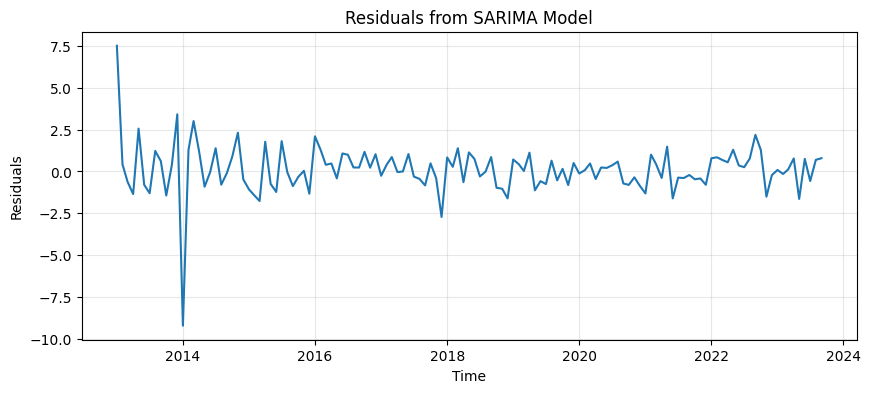

In [189]:

residuals = fitted.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals from SARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.grid(alpha=0.3)
plt.show()
pred = fitted.forecast(steps=len(test_data))
y_pred=pd.DataFrame(pred)
y_pred.index=test_data.index

In [190]:
adf_result = adfuller(residuals.dropna())
print("\nADF Test on Residuals:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")




ADF Test on Residuals:
ADF Statistic: -11.5857
p-value: 0.0000
Critical Values:
   1%: -3.4829
   5%: -2.8846
   10%: -2.5791


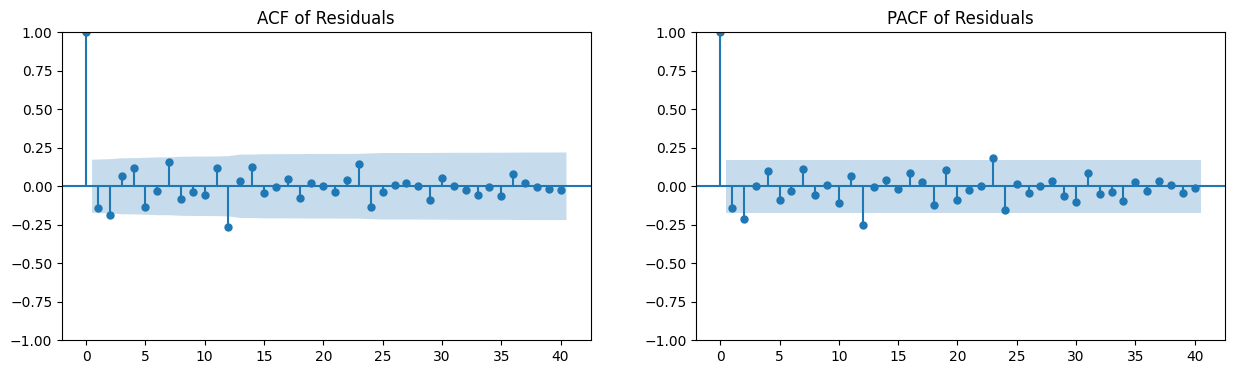

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(residuals.dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF of Residuals")
plot_pacf(residuals.dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF of Residuals")
plt.show()

In [192]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box Test Results:")

print(lb_test)  # p-value > 0.05 suggests residuals are white noise
lb_pvalue=lb_test['lb_pvalue'].values[0].round(4)
lb_pvalue
# :contentReference[oaicite:0]{index=0}

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  17.481165   0.064372


np.float64(0.0644)

In [193]:
from scipy.stats import shapiro
shap_stat, shap_p_value = shapiro(residuals.dropna())
# print(f"\nShapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")
# A p-value > 0.05 indicates that the residuals do not significantly deviate from normality

In [194]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(test_data, y_pred)
mse = mean_squared_error(test_data, y_pred)
rmse = np.sqrt(mse)
mape =  mean_absolute_percentage_error(test_data, y_pred)
print('Forecast Accuracy Metrics:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
# Interpretation:

Forecast Accuracy Metrics:
MAE: 0.5962090139537363
MSE: 0.5643483544076248
RMSE: 0.7512312256606648
MAPE: 0.07289349514684017


In [195]:
from sklearn.metrics import r2_score

final_r2 = r2_score(test_data, y_pred)
print(f"Final Model R² Score: {final_r2:.4f}")

Final Model R² Score: 0.5724


In [196]:
len(y_pred)

15

In [198]:
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(residuals.dropna(), nlags=12)  # nlags = number of lags to test
print(f"LM Statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")

LM Statistic: 35.654255797995816
p-value: 0.0003681468603852752


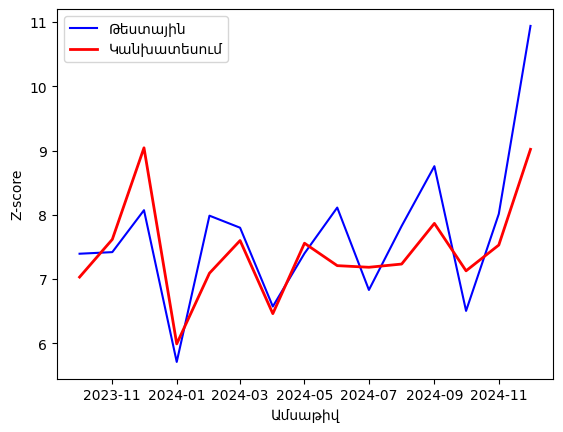

In [199]:

plt.plot(test_data, color='blue', label='Թեստային')
plt.plot(y_pred, color='red', linewidth=2, label='Կանխատեսում')
plt.xlabel('Ամսաթիվ')
plt.ylabel('Z-score')
#plt.title('ARIMA')
plt.legend()
plt.show()

In [200]:
a=pd.concat([test_data, y_pred],axis=1)
a.columns=['Atual','Predicted']
a

,Atual,Predicted
Date,,
2023-10-01,7.393699,7.030224
2023-11-01,7.418611,7.616682
2023-12-01,8.071307,9.041860
2024-01-01,5.709927,5.990653
2024-02-01,7.985911,7.090675
2024-03-01,7.798374,7.598825
2024-04-01,6.572165,6.461076
2024-05-01,7.399561,7.557212
2024-06-01,8.111913,7.208258


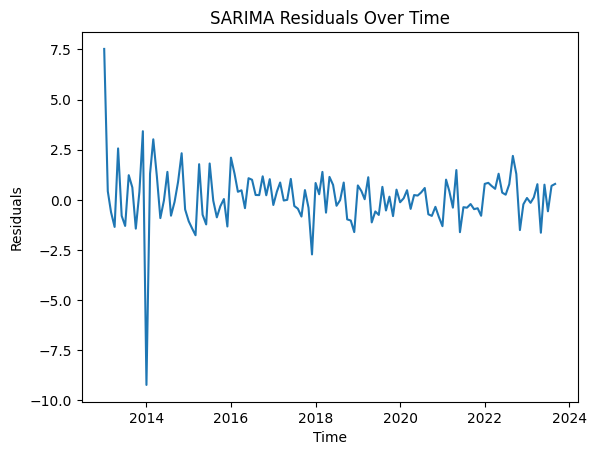

In [201]:
import matplotlib.pyplot as plt
plt.plot(residuals)
plt.title("SARIMA Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

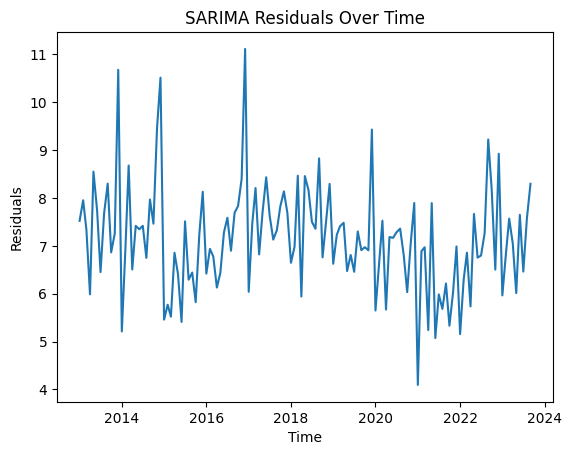

In [202]:
plt.plot(train_data)
plt.title("SARIMA Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

In [203]:
# !pip install --upgrade numpy scipy statsmodels pmdarima


In [204]:
# !pip uninstall -y numpy scipy statsmodels pmdarima
# !pip install --no-cache-dir numpy scipy statsmodels pmdarima

In [205]:
import pandas as pd

# Get the table as a string
table = fitted.summary().tables[1].as_html()

# Convert the HTML table to a DataFrame
summary_df = pd.read_html(table, header=0, index_col=0)[0]
summary_df
# # Save to CSV
#summary_df.to_csv("/content/drive/My Drive/Dissertation/sarimax_coefficientsv2.csv")

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.8049,0.091,-8.824,0.000,-0.984,-0.626
ma.L2,0.0501,0.116,0.433,0.665,-0.177,0.277
ma.S.L12,-0.9303,0.171,-5.430,0.000,-1.266,-0.595
ma.S.L24,0.0623,0.119,0.524,0.600,-0.171,0.295
sigma2,0.7541,0.156,4.833,0.000,0.448,1.060


In [206]:
##putting all test results into one table

In [207]:
df=pd.DataFrame({'Test':[], 'P-value':[]})

In [208]:
#test_vs_pred.to_csv('/content/drive/My Drive/Dissertation/Z-score_test_vs_pred.csv')

In [209]:
adf={'Test':'ADF Test','P-value' :adf_result[1]}
arch={ 'Test':'arch_test','P-value' :arch_test[1]}
shap={ 'Test':'Shapiro','P-value' :shap_p_value}
lb={'Test':'Ljung-Box','P-value' :lb_pvalue}
df = pd.concat([df, pd.DataFrame([adf])], ignore_index=True)
df=pd.concat([df, pd.DataFrame([arch])], ignore_index=True)
df = pd.concat([df, pd.DataFrame([shap])], ignore_index=True)
df = pd.concat([df, pd.DataFrame([lb])], ignore_index=True)


In [210]:
df

,Test,P-value
0,ADF Test,2.871028e-21
1,arch_test,3.681469e-04
2,Shapiro,7.176601e-12
3,Ljung-Box,6.440000e-02


In [211]:
df['P-value']=df['P-value'].apply(lambda x: format(x, 'f'))

In [212]:
df

,Test,P-value
0,ADF Test,0.000000
1,arch_test,0.000368
2,Shapiro,0.000000
3,Ljung-Box,0.064400
